In [3]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Import database

In [5]:
df = pd.read_csv('../data/Test O_G_Equipment_Data.csv', sep=';', decimal=',')
len(df)

800

In [6]:
df.head(3)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.2352,47.6573,46.4418,64.8203,66.4545,44.4832,FALSO
1,2,2,4,60.8072,63.1721,62.0060,80.7144,81.2464,60.2287,FALSO
2,3,2,1,79.0275,83.0322,82.6421,98.2544,98.7852,80.9935,FALSO


### Target Var

In [7]:
df['Fail'].value_counts()

Fail
FALSO         734
VERDADEIRO     66
Name: count, dtype: int64

In [8]:
df['Fail'].value_counts(normalize=True)

Fail
FALSO         0.9175
VERDADEIRO    0.0825
Name: proportion, dtype: float64

In [9]:
df['Target'] = np.where(df['Fail'] == "VERDADEIRO", 1, 0)

#### Defining types of columns

In [10]:
target_col = ['Target', 'Fail']
numeric_cols = df.select_dtypes(include=['float64']).columns
categorical_cols_int  = df.select_dtypes(include=['int']).drop('Target', axis = 1).columns
categorical_cols_string = df.select_dtypes(include=['object']).columns

In [11]:
print(numeric_cols)

Index(['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ',
       'Frequency'],
      dtype='object')


In [12]:
print(categorical_cols_int)

Index(['Cycle', 'Preset_1', 'Preset_2'], dtype='object')


In [14]:
print(categorical_cols_string)

Index(['Fail'], dtype='object')


### Processing data for clustering

In [15]:
base_cluster = df[numeric_cols]
for i in base_cluster.columns:
    base_cluster[i] = base_cluster[i].fillna(0.0)
scaler = StandardScaler()
scaler_model = scaler.fit(base_cluster)
data_processed = scaler_model.transform(base_cluster)

/var/folders/8v/fp9m1nfn4ys1mb8xs0x_sq2w0000gp/T/ipykernel_7530/1124566052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster[i] = base_cluster[i].fillna(0.0)


#### Elbow method

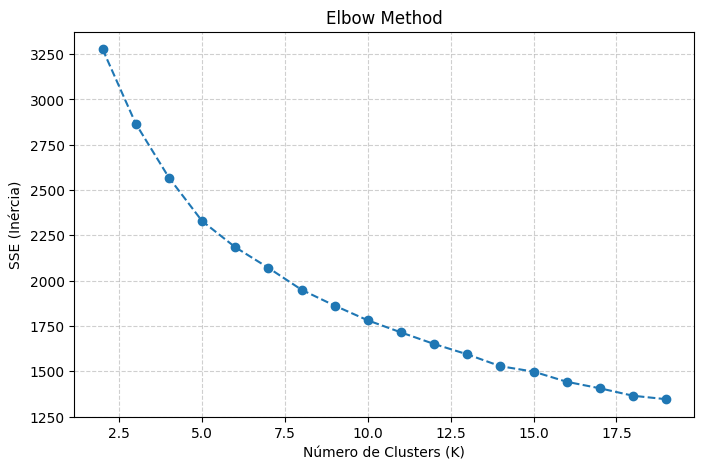

In [22]:
sse = [] # Sum of Squared Errors (Inertia)
k_range: range = range(2, 20)


for k in k_range:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(data_processed)
    sse.append(kmeans_model.inertia_)

# Plotar o Método do Cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('SSE (Inércia)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [23]:
N_CLUSTERS = 13
kmeans_final = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans_final.fit_predict(data_processed)

# Adicionar os rótulos de cluster de volta ao DataFrame original para análise
df['Cluster'] = cluster_labels

In [27]:
failure_rate_by_cluster = df.groupby('Cluster')['Target'].mean().sort_values(ascending=False)

print("\n" + "="*50)
print("INSIGHT: Failure Rate by Cluster")
print("="*50)
print(failure_rate_by_cluster.apply(lambda x: f"{x:.2%}"))


INSIGHT: Failure Rate by Cluster
Cluster
9     66.67%
4     27.27%
11    22.22%
8     21.05%
0      7.69%
2      3.12%
6      2.90%
1      0.00%
3      0.00%
5      0.00%
7      0.00%
10     0.00%
12     0.00%
Name: Target, dtype: object


In [33]:
# Inspecionar as médias das variáveis em cada cluster
cluster_profile = df.groupby('Cluster')[numeric_cols].mean()

print("\n" + "="*50)
print("Clusters Profile")
print("="*50)
print(cluster_profile)


Clusters Profile
         Temperature    Pressure  VibrationX  VibrationY  VibrationZ  \
Cluster                                                                
0          72.718131  102.525200  176.061769   66.164954   66.785738   
1          64.271826   70.361072   59.969733   71.495773   65.766614   
2          80.215673  119.856086   73.283853   70.412453   73.681319   
3          43.086488   51.072942   43.181373   49.532707   49.198234   
4          80.668504   78.356769   93.479471  104.667040  114.706829   
5          49.880638   66.512117   89.160568   44.759230   56.769238   
6          80.321187  109.822117  104.613375   60.685468   75.351912   
7         159.842040   69.988847   49.841233   68.618360   75.217713   
8          60.695505   68.506437  139.863005   68.274537  141.140105   
9         102.125664  142.333838  104.758907  129.191733  102.452500   
10         56.814628   52.220079   46.506643   45.738346   45.603521   
11         72.685784   87.990541   69.796311  

#### Insights: when all variables are high, failure rate is higher.

#### Examining Cluster Profiles - each variable

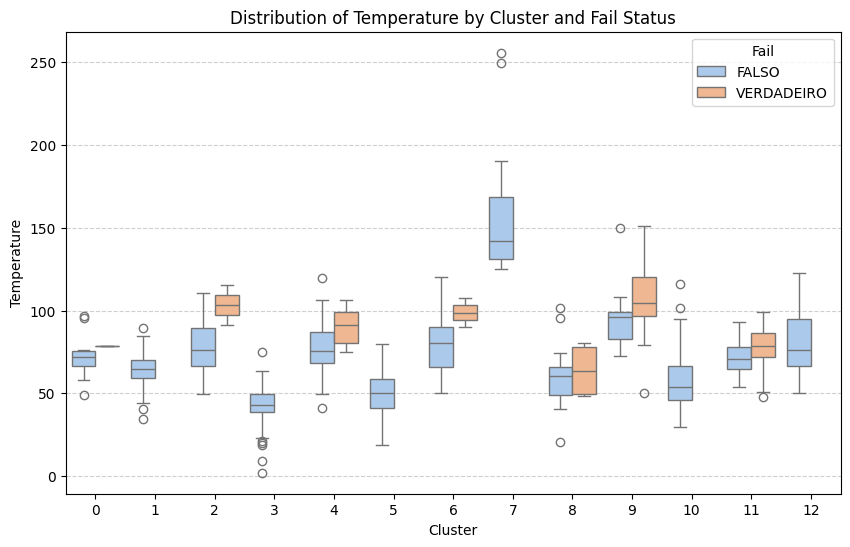

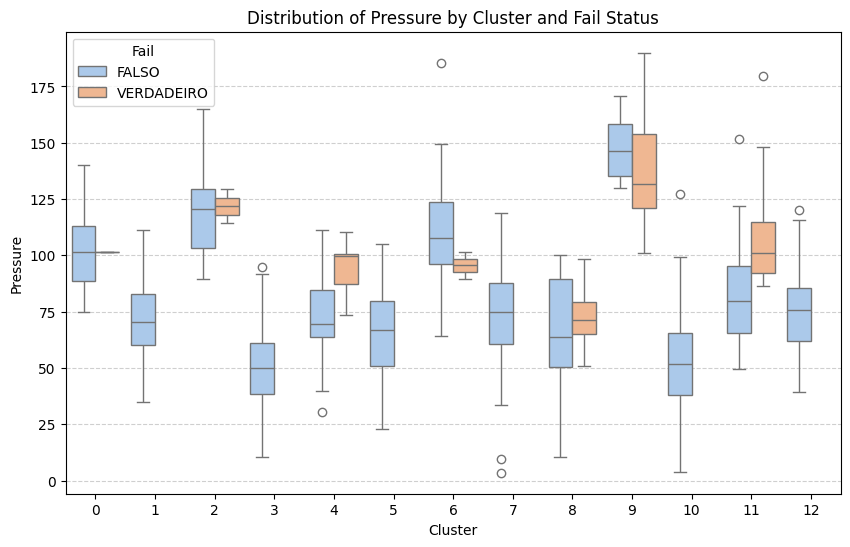

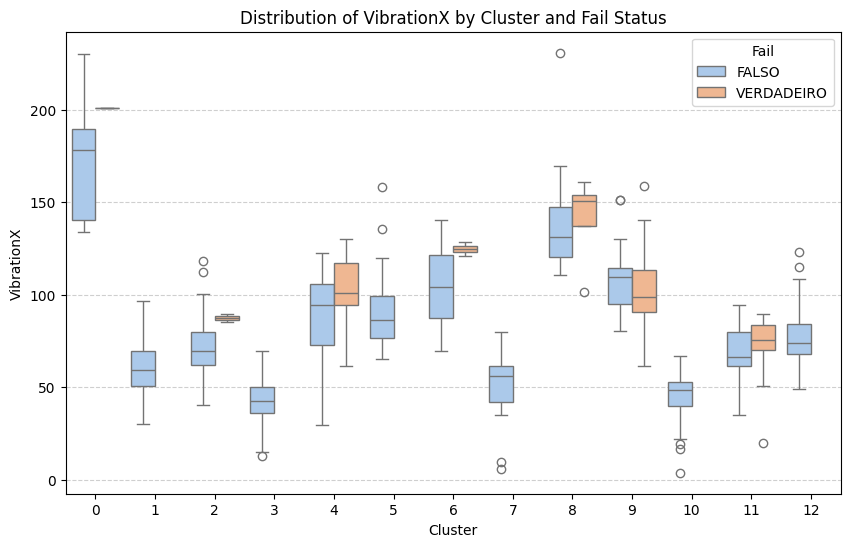

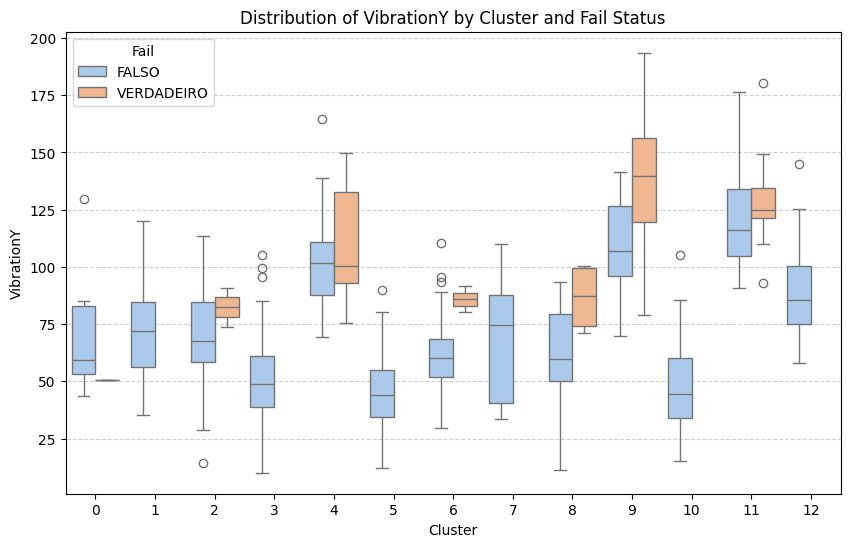

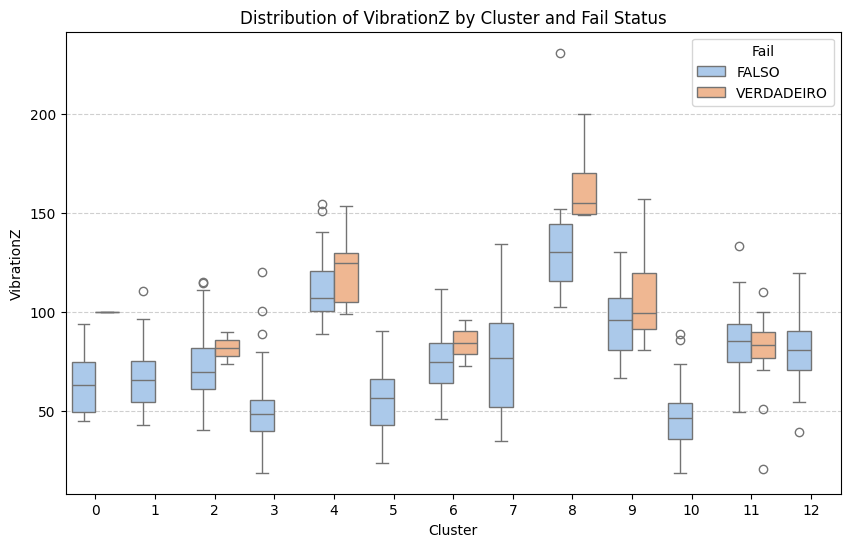

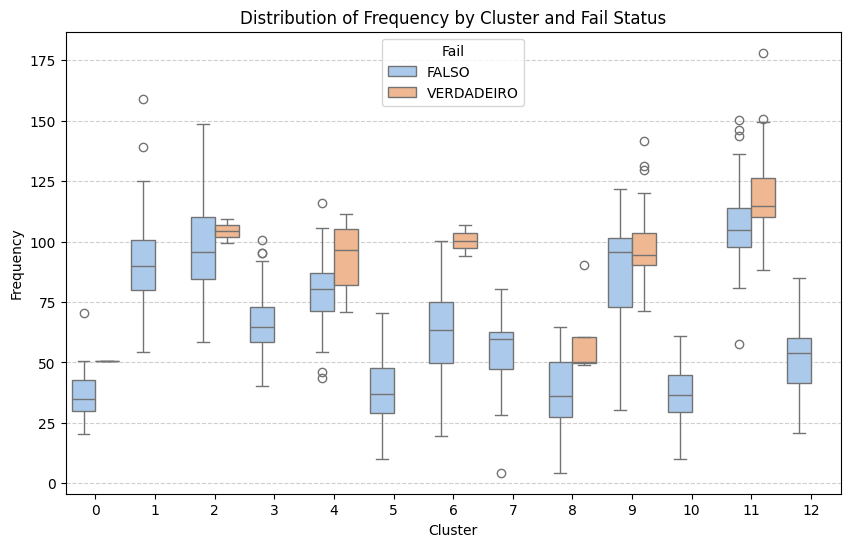

In [30]:
for i in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=i, data=df, hue='Fail', palette='pastel')
    plt.title(f'Distribution of {i} by Cluster and Fail Status')
    plt.ylabel(i)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


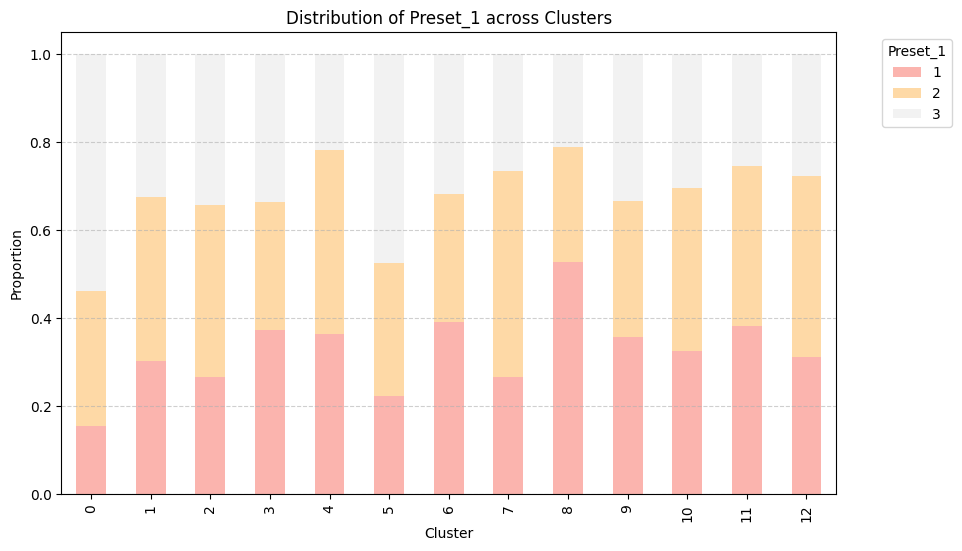

In [32]:
preset_cluster_cross1 = pd.crosstab(df['Cluster'], df['Preset_1'], normalize='index')
preset_cluster_cross1.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Pastel1')
plt.title('Distribution of Preset_1 across Clusters')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.legend(title='Preset_1', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

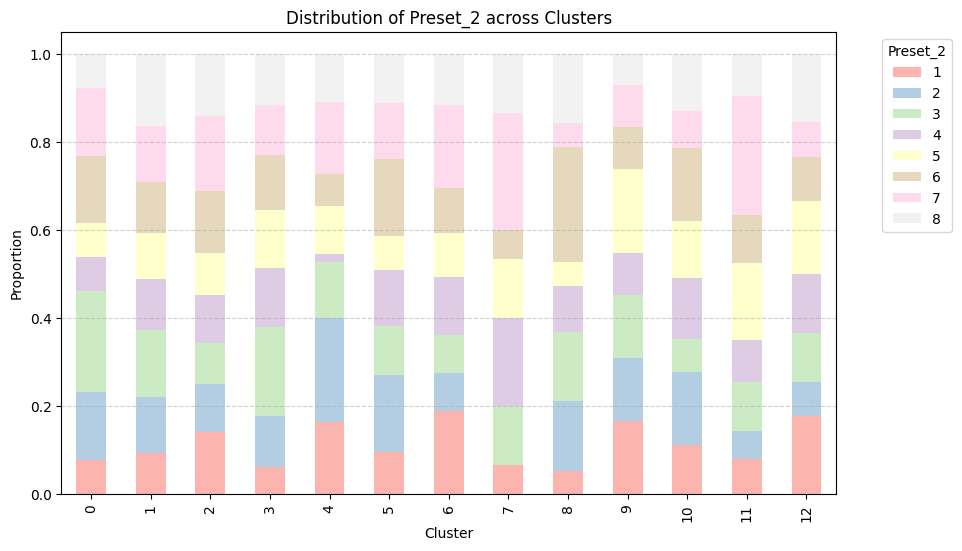

In [34]:
preset_cluster_cross2 = pd.crosstab(df['Cluster'], df['Preset_2'], normalize='index')
preset_cluster_cross2.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Pastel1')
plt.title('Distribution of Preset_2 across Clusters')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.legend(title='Preset_2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Presets doesnt appear to explain the failure rate so good